/tmp/ipykernel_3577210/528455106.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PFT', y=parameter, data=df_diff, ax=axes[i], palette=colors)
/tmp/ipykernel_3577210/528455106.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PFT', y=parameter, data=df_diff, ax=axes[i], palette=colors)
/scratch/c7071034/conda_envs/pyrealm/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_3577210/528455106.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

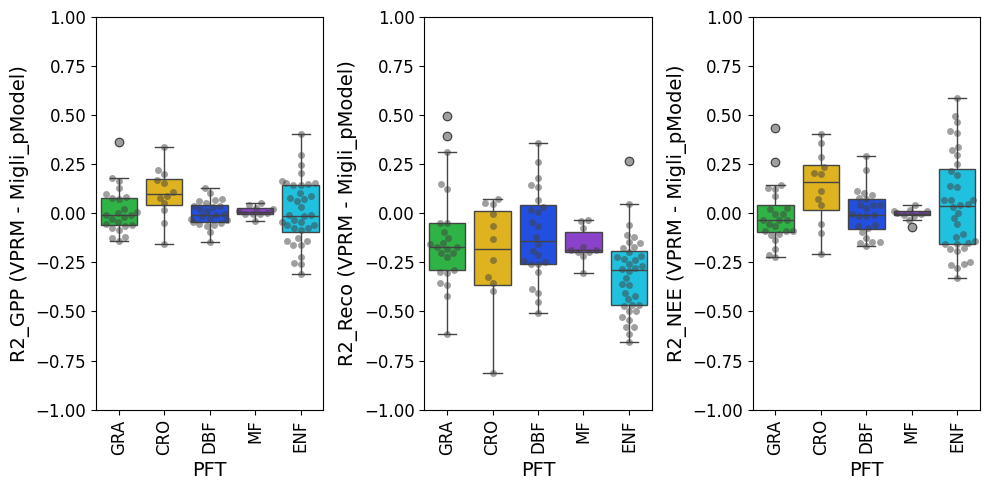

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

version = "V20"
iterations = "10"
R2_lt_zero = True  # Test to see results for R2_lt_zero - default: True (deletes sites below zero R2)
CO2_parametrization1 = "old"
CO2_parametrization2 = "migli" # "migli" or "new"
for region in ["Alps"]:  # ,"Europe"
    run_ID = region + "_VPRM_optimized_params_diff_evo_" + version + "_" + iterations
    # base_path = "/home/madse/Downloads/Fluxnet_Data/all_tuned_params/" + run_ID
    # print(f"Processing {run_ID}")
    base_path = "/scratch/c7071034/DATA/Fluxnet2015/Alps/"

    # Initialize DataFrames for old and migli parameterizations
    df_parameters_old = pd.DataFrame()
    df_parameters_migli = pd.DataFrame()

    # Load the data for both "old" and "migli" CO2 parameterizations
    for CO2_parametrization in [CO2_parametrization1 ,CO2_parametrization2]:
        folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
        flx_folders = [folder for folder in folders if folder.startswith("FLX_")]

        if not flx_folders:
            print("Warning - There is no input data")
            raise SystemExit(0)

        # Loop through each FLX_ folder and append data from XLSX files
        for folder in flx_folders:
            folder_path = os.path.join(base_path, folder)
            files = [f for f in os.listdir(folder_path) if f.endswith(CO2_parametrization + '_diff_evo_' + version + '_' + iterations + '.xlsx')]
            for file in files:
                file_path = os.path.join(folder_path, file)
                data = pd.read_excel(file_path)
                
                # Append the data to the correct DataFrame
                if CO2_parametrization == "old":
                    df_parameters_old = pd.concat([df_parameters_old, data], axis=0)
                else:
                    df_parameters_migli = pd.concat([df_parameters_migli, data], axis=0)


    # Filter out sites with R2_NEE < 0 if R2_lt_zero is True
    if R2_lt_zero:
        df_parameters_old = df_parameters_old[df_parameters_old["R2_NEE"] > 0].reset_index(drop=True)
        df_parameters_migli = df_parameters_migli[df_parameters_migli["R2_NEE"] > 0].reset_index(drop=True)
    else:
        df_parameters_old = df_parameters_old[df_parameters_old["R2_NEE"] < 0].reset_index(drop=True)
        df_parameters_migli = df_parameters_migli[df_parameters_migli["R2_NEE"] < 0].reset_index(drop=True)

    # Check if both DataFrames are populated
    if df_parameters_old.empty or df_parameters_migli.empty:
        print("Error: One of the DataFrames is empty. Check if the files are loaded correctly.")
        raise SystemExit(0)

    # Calculate the difference between the "old" and "migli" parametrizations
    df_diff = df_parameters_old.copy()
    # for parameter in ['R2_GPP', 'RMSE_GPP', 'MAE_GPP', 'R2_Reco', 'RMSE_Reco', 'MAE_Reco', 'R2_NEE', 'RMSE_NEE', 'MAE_NEE']:
    for parameter in ['R2_GPP', 'R2_Reco', 'R2_NEE']:
        df_diff[parameter] = df_parameters_old[parameter] - df_parameters_migli[parameter]

    # Plot the differences
    sns.color_palette('bright')
    color_palette = sns.color_palette('bright')
    pft_colors = {
        'CRO': color_palette[8],
        'DBF': color_palette[0],
        'ENF': color_palette[9],
        'MF': color_palette[4],
        'GRA': color_palette[2],
        'SHB': color_palette[7],
        'WET': color_palette[3]
    }

    # Create a list of colors for the boxplot based on the sorted PFTs
    pft_order = df_diff['PFT'].unique()
    colors = [pft_colors[pft] for pft in pft_order]

    # parameters_to_plot = ['R2_GPP', 'RMSE_GPP', 'MAE_GPP', 'R2_Reco', 'RMSE_Reco', 'MAE_Reco', 'R2_NEE', 'RMSE_NEE', 'MAE_NEE']
    # fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 15))
    parameters_to_plot = ['R2_GPP', 'R2_Reco','R2_NEE']
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    axes = axes.flatten()
    font_size = 12
    if CO2_parametrization2 == 'migli':
        CO2_parametrization1 = "VPRM"
        CO2_parametrization2 = "Migli_pModel"

    for i, parameter in enumerate(parameters_to_plot):
        sns.boxplot(x='PFT', y=parameter, data=df_diff, ax=axes[i], palette=colors)
        sns.swarmplot(x='PFT', y=parameter, data=df_diff, color="0.25", alpha=0.5, ax=axes[i])
        axes[i].set_xlabel('PFT', fontsize=font_size+2)
        axes[i].set_ylabel(parameter + f" ({CO2_parametrization1} - {CO2_parametrization2})", fontsize=font_size+2)
        axes[i].tick_params(axis='x', rotation=90)
        axes[i].tick_params(axis='both', which='major', labelsize=font_size)
        # Set limits for R2 difference
        if 'R2' in parameter:
            axes[i].set_ylim(-1, 1)

    plt.tight_layout()
    plt.savefig(
        base_path +
        "/boxplot_R2_RMSE_diff_"
        + CO2_parametrization1 
        + "-"
        + CO2_parametrization2
        + "_"
        + run_ID
        + ".png",
        dpi=300,
        bbox_inches="tight",
    )
